## Dog v/s Cat Classifier

You can use this notebook to train our dog v/s cat classifier. FastAI makes it super easy to train the models too, under 10 lines of code we have a descent classifier!

In [2]:
!pip -q install fastai>-2.2.7

In [3]:
from fastai.vision.all import *
from pathlib import Path

In [4]:
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/annotations')]

In [5]:
files = get_image_files(path/"images")
len(files)

7390

In [6]:
from dogvscat_utils import label_func

dls = ImageDataLoaders.from_name_func(path, files, 
                                      label_func, 
                                      item_tfms=Resize(224),num_workers=0)

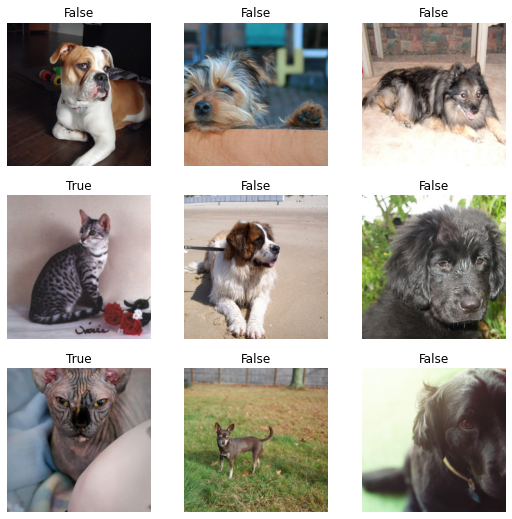

In [7]:
dls.show_batch()

As you can see we have the images ready to be loaded for training. We are going to use a resnet34 and finetune on top of that. Lets see what how it goes

In [8]:
learn = cnn_learner(dls, resnet34, metrics=error_rate, path='./saved_models')
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.161427,0.244009,0.076455,01:12


epoch,train_loss,valid_loss,error_rate,time
0,0.085299,0.589866,0.119080,01:07
1,0.030677,0.127817,0.041272,01:07


In [9]:
files

(#7390) [Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/english_setter_100.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/British_Shorthair_88.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/Abyssinian_43.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/beagle_198.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/great_pyrenees_133.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/saint_bernard_52.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/beagle_30.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/Bengal_24.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/Siamese_249.jpg'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_56.jpg')...]

In [10]:
learn.predict(files[0])

('False', tensor(0), tensor([0.9952, 0.0048]))

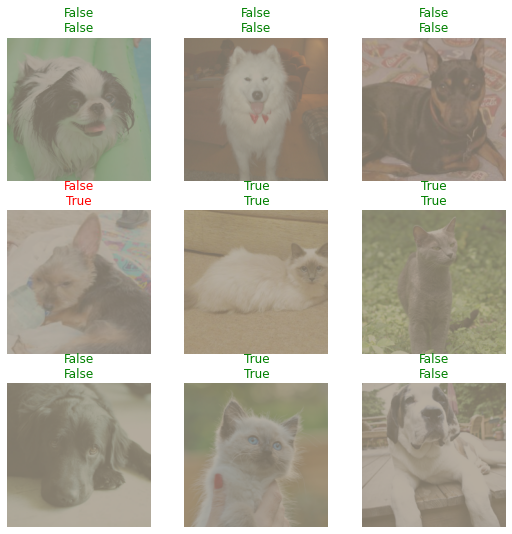

In [11]:
learn.show_results()

With just 2 epoch of training we have created a fairly descent classifier for dogs and cats, good on ya mate!

Now lets save it and generate the final model file. 

In [14]:
learn.export('model.pkl')
print('Saved to: ', learn.path)

Saved to:  saved_models


## Inference
Now lets figure out the about loading the models and running the inference. 

In [16]:
os.listdir('test_images/')

['d3.jpg', 'd1.jpg', 'c2.jpg', 'd2.jpg', 'c1.jpg', 'c3.jpg']

In [17]:
from dogvscat_utils import label_func

loaded_learner = load_learner('./saved_models/model.pkl')

In [18]:
files = get_image_files('test_images')
dl = loaded_learner.dls.test_dl(files)
dl

In [19]:
files

(#6) [Path('test_images/d3.jpg'),Path('test_images/d1.jpg'),Path('test_images/c2.jpg'),Path('test_images/d2.jpg'),Path('test_images/c1.jpg'),Path('test_images/c3.jpg')]

In [20]:
loaded_learner.get_preds(dl=dl)

(tensor([[2.0493e-02, 9.7951e-01],
         [9.8556e-01, 1.4442e-02],
         [2.1741e-16, 1.0000e+00],
         [9.9650e-01, 3.4975e-03],
         [5.2396e-14, 1.0000e+00],
         [1.1011e-16, 1.0000e+00]]),
 None)

In [25]:
!pip install  bentoml

In [27]:
from bentoservice import DogVCatService

svc = DogVCatService()
svc.pack('learner', loaded_learner)
svc.save_to_dir('bento_service/')


[2021-03-10 17:50:03,838] WARNING - BentoML by default does not include spacy and torchvision package when using FastaiModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService
[2021-03-10 17:50:03,840] WARNING - pip package requirement torch already exist
[2021-03-10 17:50:03,843] WARNING - pip package requirement fastcore already exist
[2021-03-10 17:50:03,844] WARNING - pip package requirement fastai>=2.0.0 already exist
[2021-03-10 17:50:04,357] INFO - BentoService bundle 'DogVCatService:20210310175003_DA5FB9' created at: bento_service/


In [29]:
saved_path = svc.save()

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


[2021-03-10 17:50:27,130] INFO - BentoService bundle 'DogVCatService:20210310175003_DA5FB9' saved to: /home/ec2-user/bentoml/repository/DogVCatService/20210310175003_DA5FB9


In [30]:
!bentoml  list

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
BENTO_SERVICE                         AGE                         APIS                              ARTIFACTS                     LABELS
DogVCatService:20210310175003_DA5FB9  1 minute and 39.46 seconds  predict<FileInput:DefaultOutput>  learner<FastaiModelArtifact>


In [31]:
!bentoml serve DogVCatService:20210310175003_DA5FB9

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
[2021-03-10 17:52:29,058] INFO - Starting BentoML API server in development mode..
[2021-03-10 17:52:31,301] WARNING - BentoML by default does not include spacy and torchvision package when using FastaiModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService
 * Serving Flask app "DogVCatService" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+

In [49]:
# send file for inference
!curl -i -X  POST "http://localhost:5000/predict" \
  -F image=@d1.jpg  

curl: (26) Failed to open/read local data from file/application


In [33]:
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

arn:aws:iam::785315722499:role/sagemaker-deployment


In [ ]:
try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='AmazonSageMaker-ExecutionRole-20201200T100000')['Role']['Arn']

In [42]:
import boto3
iam = boto3.client('iam')
role = iam.get_role(RoleName='sagemaker-mau')['Role']['Arn']
role

'arn:aws:iam::785315722499:role/sagemaker-mau'

In [45]:
!bentoml sagemaker deploy dogcats -b DogVCatService:20210310175003_DA5FB9 --api-name predict

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
Deploying Sagemaker deployment |[2021-03-10 19:42:29,239] INFO - Step 1/9 : FROM bentoml/model-server:0.11.0-py36
[2021-03-10 19:42:29,239] INFO - 

[2021-03-10 19:42:29,239] INFO -  ---> 7407abcf81d5

[2021-03-10 19:42:29,239] INFO - Step 2/9 : ENV PORT 8080
[2021-03-10 19:42:29,240] INFO - 

[2021-03-10 19:42:29,240] INFO -  ---> Using cache

[2021-03-10 19:42:29,240] INFO -  ---> 37acaf9f1333

[2021-03-10 19:42:29,240] INFO - Step 3/9 : EXPOSE $PORT
[2021-03-10 19:42:29,240] INFO - 

[2021-03-10 19:42:29,240] INFO -  ---> Using cache

[2021-03-10 19:42:29,240] INFO -  ---> 71270acb5bc6

[2021-03-10 19:42:29,241] INFO - Step 4/9

In [44]:
#!bentoml deployment delete dogcats


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
Successfully deleted deployment "dogcats"


In [48]:
#url = https://runtime.sagemaker.us-east-2.amazonaws.com/endpoints/dev-dogcats/invocations
!curl -i -X  POST "https://runtime.sagemaker.us-east-2.amazonaws.com/endpoints/dev-dogcats/invocations:5000/predict" \
  -F image=@d1.jpg    

curl: (26) Failed to open/read local data from file/application


In [51]:
!ping runtime.sagemaker.us-east-2.amazonaws.com/endpoints/dev-dogcats/invocations

ping: unknown host runtime.sagemaker.us-east-2.amazonaws.com/endpoints/dev-dogcats/invocations
